In [2]:
import numpy as np
from scipy.fft import fft, fftfreq, fftshift
from scipy.signal import welch
from scipy.signal.windows import hamming, hann
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('./nikhils_plot_style.mplstyle')

Johnson noise PSD for 1 kOhm resistor at 300 K is 1.6567782239999996e-17 V^2/Hz


Sampling frequency is 2000010.0000000002 Hz
Et = 48384.95625746564 & Ek = 48386.06273417628


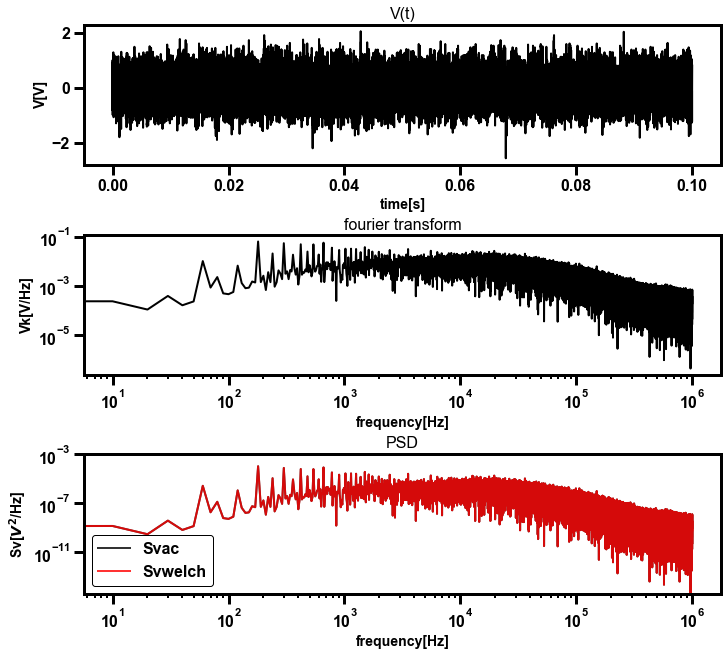

Svfft:
max=0.002011242134293782	min=9.31323172646592e-14
Svwelch:
max=0.00010056160390666959	min=4.656592580270059e-15
Svac:
max=0.00010056160390666961	min=4.656592254651379e-15
##################################################
sum of Svfft = 0.24193031367088141
sum of Svwelch = 0.01209590136013653
sum of Svac = 0.012096455201268027
Median noise between 1 KHz and 10 KHz is 5.122328612862461e-07 V^2/Hz


In [52]:
######################################################################################
def johnson_noise_psd(T, R):
    k = 1.38064852e-23 # Boltzmann constant in J/K
    return 4*k*T*R
print(f"Johnson noise PSD for 1 kOhm resistor at 300 K is {johnson_noise_psd(300, 1e3)} V^2/Hz")
#######################Simulated signal#######################################
dt = 0.0001 # time step in s
T = 2 # total time in s
fs = int(1/dt) # sampling frequency in Hz
N = int(T/dt) #number of points
time = np.arange(0,T,dt) # time in seconds
# print(f"Sampling frequency is {1/dt} Hz")

fnoise_1 = 50 # noise frequency in Hz
Anoise_1 = 1 # noise amplitude

fnoise_2 = 120 # noise frequency in Hz
Anoise_2 = 0.7 # noise amplitude

V = Anoise_1*np.sin(2*np.pi* fnoise_1* time) + Anoise_2*np.sin(2*np.pi* fnoise_2* time)
######################################################################################
############### data from single acquisition##############################################
######################################################################################
# fp = "./data/data_1KOhm_single.csv"
# fp="./data/scope_7_1.csv"# wire connected to the function generator
# fp="./data/scope_13_1.csv"# 1 kOhm, time = 2 s, 100_000 samples
# fp="./data/scope_17_1.csv"# 15 kOhm, time = 0.1 s, 200_000 samples
# fp="./data/scope_18_1.csv"# 15 kOhm, time = 0.1 s, 200_000 samples
# fp="./data/scope_19_1.csv"# 1 kOhm, time = 0.1 s, 200_000 samples
# fp="./data/scope_20_1.csv"# 1 kOhm, time = 0.1 s, 200_000 samples
# fp="./data/scope_21_1.csv"# 100 kOhm, time = 0.1 s, 200_000 samples
# fp="./data/scope_22_1.csv"# 100 kOhm, time = 0.1 s, 200_000 samples
fp="./data/scope_23_1.csv"# 100 kOhm, time = 0.1 s, 200_000 samples, bandpass filter, 1 KHz to 100 KHz
# fp="./data/scope_1.csv"# 100 KHz from function generator

df=pd.read_csv(fp,header=0,sep=",",skiprows=1, names=["time", "voltage"])
df.head()

T = df["time"].max()-df["time"].min() # seconds
N = df.shape[0]
fs = int(N/T) # Hz
dt = 1/fs
time = df["time"].to_numpy() - df["time"].min()
print(f"Sampling frequency is {1/dt} Hz")

V = df["voltage"].to_numpy()
#########################################################################################


#Discrete Fourier transform of V
Vk = np.absolute(fftshift(fft(V)))
Vk = 2*Vk[Vk.size//2:] # folding and only selecting positive frequencies
Vk = Vk/N # normalizing
fk = fftfreq(N,dt)
fk = fk[:fk.size//2]

# Energy calculation
Et = np.sum(np.absolute(V)**2)
Ek = np.sum(np.absolute(Vk)**2)*(N/2)

print(f"Et = {Et} & Ek = {Ek}")

#PSD from FFT
Svfft = (1/2)*np.absolute(Vk)**2

#PSD from welch
fwelch, Svwelch = welch(V, fs=fs, window='boxcar', nperseg=N, noverlap=0, return_onesided=True, scaling='density', axis=-1)
Svwelch = (1/2)*Svwelch

# PSD from autocorrelation
def correlation_nik_vectorized(V1, V2):
    assert V1.size==V2.size
    n = V1.size
    lags = list(range(0,n,1))
    V2doubled = np.concatenate((V2,V2))
    cor = np.zeros(n)
    for lag in lags:
        cor[lag] = V1.dot(V2doubled[lag:lag+n])
    cor = cor/n
    return cor


ac = correlation_nik_vectorized(V,V)
Svac = np.absolute(fftshift(fft(ac)))
Svac = Svac[Svac.size//2:]
Svac = Svac/fs

#plot
fig, (ax1,ax2, ax3) = plt.subplots(3,1, figsize=(10,9), constrained_layout=True)

ax1.plot(time, V)
ax1.set_xlabel("time[s]")
ax1.set_ylabel("V[V]")
ax1.set_title("V(t)")

ax2.plot(fk, Vk)
ax2.set_xlabel("frequency[Hz]")
ax2.set_ylabel("Vk[V/Hz]")
ax2.set_title("fourier transform")
ax2.set_xscale('log')
ax2.set_yscale('log')


# ax3.plot(fk, Svfft, alpha=0.8, label = "Svfft")
ax3.plot(fk, Svac, alpha=0.8, label = "Svac")
ax3.plot(fwelch, Svwelch, alpha=0.8, label = "Svwelch")
ax3.set_xlabel("frequency[Hz]")
ax3.set_ylabel("Sv[$V^2$/Hz]")
ax3.set_title("PSD")
ax3.set_ylim(Svwelch[10:].min()*0.9,Svwelch[10:].max()*10)
ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.legend()

plt.show()

print(f"Svfft:\nmax={(Svfft.max())}\tmin={(Svfft[10:].min())}")
print(f"Svwelch:\nmax={(Svwelch.max())}\tmin={(Svwelch[10:].min())}")
print(f"Svac:\nmax={(Svac.max())}\tmin={(Svac[10:].min())}")
print(50*'#')
print(f"sum of Svfft = {np.sum(Svfft)}")
print(f"sum of Svwelch = {np.sum(Svwelch)}")
print(f"sum of Svac = {np.sum(Svac)}")

print(f"Median noise between 1 KHz and 10 KHz is {np.median(Svac[np.where((fk>5000) & (fk<90_000))])} V^2/Hz")

In [41]:
fps = ["./data/scope_19_1.csv", "./data/scope_17_1.csv", "./data/scope_21_1.csv"]
dfs = []
for fp in fps:
    df=pd.read_csv(fp,header=0,sep=",",skiprows=1, names=["time", "voltage"], index_col=0)
    dfs.append(df)

df_merged = pd.concat(dfs, ignore_index=True, axis=1)
df_merged.columns = [1, 2, 3]
df_merged.head()
df_merged.reset_index(inplace=True)
df_merged.head()

,time,1,2,3
0,-0.050000,-0.281407,1.648240,2.090450
1,-0.050000,0.120603,-0.844221,-1.005030
2,-0.049999,0.100503,1.567840,-0.683417
3,-0.049999,-0.301508,1.286430,1.286430
4,-0.049998,0.221106,-1.085430,-0.402010


Sampling frequency is 2000010.0000000002 Hz


IndexError: index 3 is out of bounds for axis 1 with size 3

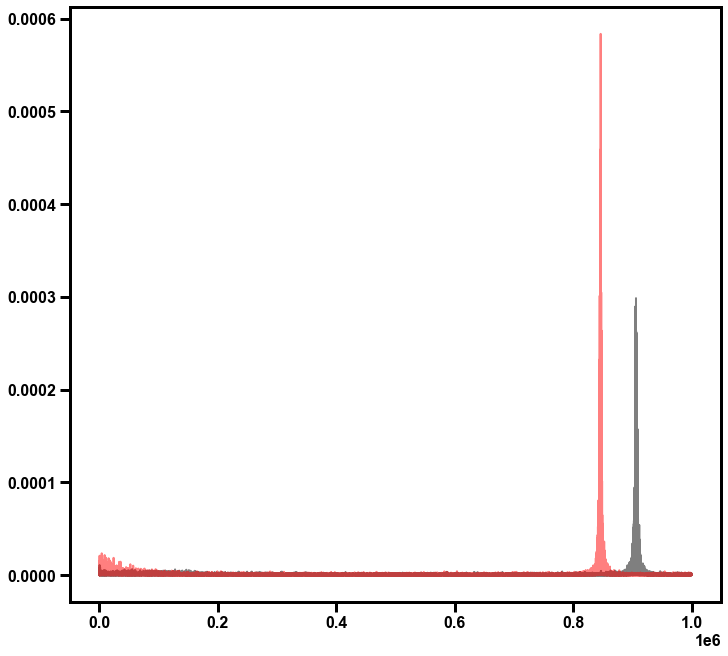

In [42]:


# fp="./data/data_1.csv"
# # fp = "./data/data_1KOhm_single.csv"
# df=pd.read_csv(fp,header=None,sep=",")
# df.rename(columns={0:"time"}, inplace=True)
# df.head()

fps = ["./data/scope_19_1.csv", "./data/scope_17_1.csv", "./data/scope_21_1.csv"]
dfs = []
for fp in fps:
    df_tmp=pd.read_csv(fp,header=0,sep=",",skiprows=1, names=["time", "voltage"], index_col=0)
    dfs.append(df_tmp)

df = pd.concat(dfs, ignore_index=True, axis=1)
df.columns = [1, 2, 3]
df.reset_index(inplace=True)
df.head()

T = df["time"].max()-df["time"].min() # seconds
N = df.shape[0]
fs = int(N/T) # Hz
dt = 1/fs
time = df["time"].to_numpy() - df["time"].min()
print(f"Sampling frequency is {1/dt} Hz")

Svac_list = np.zeros((df.shape[0]//2, df.shape[1]-1))

for i in range(1,df.shape[1]):
    V = df[i].to_numpy()
    ac = correlation_nik_vectorized(V,V)
    Svac = np.absolute(fftshift(fft(ac)))
    Svac = Svac[Svac.size//2:]
    Svac = Svac/fs
    Svac_list[:,i-1] = Svac

# Svac_mean = np.mean(Svac_list, axis=1)

fk = fftfreq(N,dt)
fk = fk[:fk.size//2]

fig, ax = plt.subplots(figsize=(10,9), constrained_layout=True)
ax.plot(fk, Svac_list[:,1], alpha=0.5, label = "1KOhm")
ax.plot(fk, Svac_list[:,2], alpha=0.5, label = "15KOhm")
ax.plot(fk, Svac_list[:,3], alpha=0.5, label = "100KOhm")

# ax.plot(fk, Svac_mean, alpha=1, label = "Svac_mean")
ax.set_xlabel("frequency[Hz]")
ax.set_ylabel("Sv[$V^2$/Hz]")
# ax.set_ylim(Svac_[5:].min()*0.9,Svac_mean[5:].max()*10)
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()
plt.show()

In [53]:
johnson_noise_psd(300, 100e3)*(50_000)**2

4.141945559999999e-06

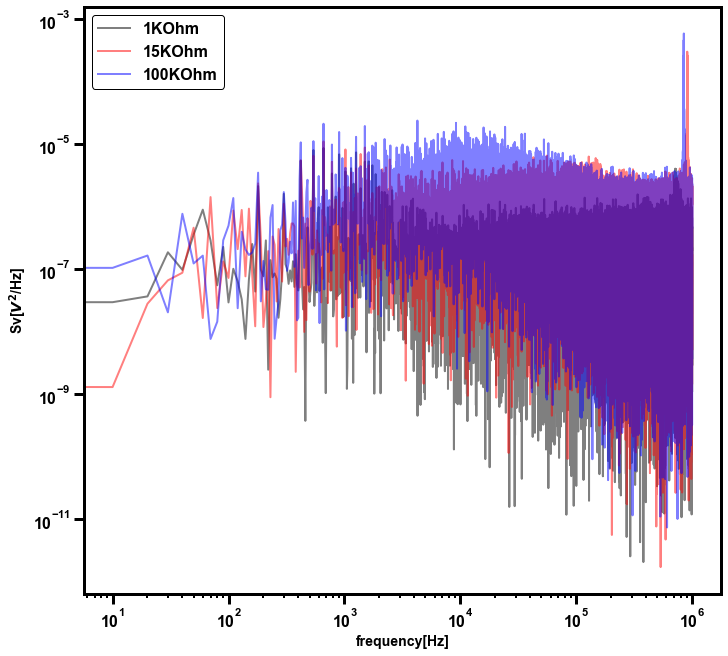

In [50]:
fig, ax = plt.subplots(figsize=(10,9), constrained_layout=True)
ax.plot(fk, Svac_list[:,0], alpha=0.5, label = "1KOhm")
ax.plot(fk, Svac_list[:,1], alpha=0.5, label = "15KOhm")
ax.plot(fk, Svac_list[:,2], alpha=0.5, label = "100KOhm")

# ax.plot(fk, Svac_mean, alpha=1, label = "Svac_mean")
ax.set_xlabel("frequency[Hz]")
ax.set_ylabel("Sv[$V^2$/Hz]")
# ax.set_ylim(Svac_[5:].min()*0.9,Svac_mean[5:].max()*10)
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()
plt.show()

In [46]:
for i in range(3):
    print(np.median(Svac_list[:,i][np.where((fk>30_000) & (fk<100_000))]))

9.988351074617887e-08
5.131114565824959e-07
7.526157213980881e-07


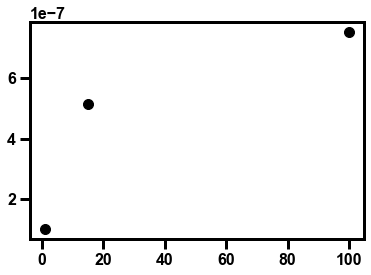

In [47]:
plt.plot([1,15,100], [np.median(Svac_list[:,i][np.where((fk>30_000) & (fk<100_000))]) for i in range(3)], 'o')
johnson_noise_psd(300, 15e3)*(50_000)**2
plt.show()